---
**Chapter 08**
# **Introduction to deep learning for computer vision**
---


In [24]:
# System Libraries
from tensorflow import keras
import os, shutil, pathlib
import tensorflow as tf
import numpy as np
import importlib
import sys

sys.path.append("../")

# User Libraries
from modules import Chapter_01
from modules import Chapter_08
from modules import Common

# Reload Libraries
importlib.reload(Chapter_01)
importlib.reload(Chapter_08)
importlib.reload(Common)

<module 'modules.Common' from '/Users/siddiqui/Projects/concepts/concepts-ai/notebooks/../modules/Common.py'>

---
# **Convolution theory**
---


### <ins />**Convolution layers**
  - Dense layers learn patterns of global input feature map
  - Conv layers learn patterns of local input patch
  - Convolution classification network has two parts:
     - Convolution base: Conv2D + Maxpooling
     - Logit: Dense
  - Convolution base:
    - Lower layers extract specific feature maps
    - Upper layers extract highly generic feature maps
  - Translation invariant patterns
    - After learning a pattern once, Conv layer can infer it anywhere in the image
  - Spatial hierarchical patterns
    - Upper layers learn generic patterns
    - Lower layers learn specific patterns
  - For problems where object location matters, dense layer is useless
  - Dense layer is also called fully connected layer

### <ins />**Feature map**
  - Height, Width, Channels (H, W, D)
  - Feature map size: HxW
  - Feature map depth: D
  - For larger images, we increase number of layers:
    - To increase feature map depth
    - To decrease feature map size
    - To increase model capacity
  - In a convnet
    - Feature map depth increases with each layer
    - Feature map size decreases with each layer
  
### <ins />**Input feature map (3D)**
  - 28x28x1 matrix input image

### <ins />**Filter**
  - Depth of output feature map
  - 32, 64, etc.

### <ins />**Kernel (2D)**
  - 3x3 matrix aka convolution kernel / structuring element
  - Same kernel is used with all input patches

### <ins />**Input patch (2D)**
  - 3x3 matrix patch of input feature map

### <ins />**Reponse map (1D)**
  - 3x1 Tensorproduct of kernel and input patch

### <ins />**Output feature map (3D)**
  - Combine all response maps into matrix
  
### <ins />**Convolution operation (sliding window)**
  1. Slide the kernel on input feature map
  2. Extract input patch
  3. Tensor product the kernel and input patch to get response map vector
  4. Combine all response map vectors (one per patch) to get output feature map
  5. Output map size is less than input map size due to convolution border effect and stride

### <ins />**Padding**
  - To counter border effect i.e. in order to have output map size equals input map size
  - Valid padding
    - No padding applied (default)
    - Output map size < Input map size
  - Same padding
    - Padding applied
    - Output map size = Input map size
    - Padding size depends on kernel size, not on input patch size
    - Padding for 3x3 kernel:
      - 1x row on top. 1x row on bottom
      - 1x column on right. 1x column on left
    - Padding for 5x5 kernel:
      - 2 rows on top. 2 rows on bottom
      - 2 columns on right. 2 columns on left

### <ins />**Stride**
  - Distance between two consecutive convolution windows
  - Not used in classification convnets (see maxpooling)
  - Downsampling mechanism
  - Stride=1 (default)

### <ins />**Maxpooling**
  - Max patch: 2x2 matrix of max value of input patch
  - Tensorproduct of max patch and input patch
  - Used in classification convnets 
  - Downsampling mechanism

### <ins />**Convolution vs Maxpooling vs Avgpooling**
  - Maxpooling:
    - Kernel=2x2 (pool size)
    - Stride=2
    - **Kernel uses max value of input patch**
    - Feature map size is reduced by **size / 2**
  - Avgpooling:
    - Kernel=2x2 (pool size)
    - Stride=2
    - **Kernel uses average value of input patch**
    - Feature map size is reduced by **size / 2**
  - Convolution:
    - Kernel=3x3 (kernel size)
    - Stride=1
    - **Kernel uses fixed value irrespective of input patch**
    - Feature map size is reduced by **size - 2**

### <ins />**Why downsample (stride / maxpooling / avgpooling)**
  - Reduce number of coefficients and overfit
    - Without maxpooling = 61952 coefficients 
    - With maxpooling = 1152 coefficients  
  - Increase channel-to-height/width ratio
    - Without maxpooling = 24x24x64
    - With maxpooling = 11x11x64

### <ins />**Data Augmentation**
   - Remix the already available information
   - No new information created
   - To further reduce overfit, use dropout

### <ins />**Transfer learning**
  - Models trained on large dataset (different classes) serve as generic model of visual world
  - E.g. Model trained on ImageNet (animals) used as base model for bottle detection
  - Deep learning with convet is effective for small dataset due to  transfer learning
  - Types of transfer learning: 
    - Feature extraction
    - Fine tuning

### <ins />**Feature extraction**
  - Take convolutional base of another model and add a new fully connected (dense) logit layer
  - New dataset has different classes: Use upper layers of convolution base
  - New dataset has similar classes: Use all layers of convolution base
  - Using logit layer from another model **should be avoided**


### <ins />**Maxpooling and padding use cases**

##### **Case-1: No padding. No maxpooling**

In [2]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(inputs)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
keras.Model(inputs=inputs, outputs=outputs).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 61952)             0         
                                                                 
 dense (Dense)               (None, 10)                619530    
                                                                 
Total params: 712202 (2.72 MB)
Trainable params: 712202 (2.72

##### **Case-2: With padding. No maxpooling**

In [3]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation=tf.nn.relu)(inputs)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
keras.Model(inputs=inputs, outputs=outputs).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 10)                1003530   
                                                                 
Total params: 1096202 (4.18 MB)
Trainable params: 1096202 (

##### **Case-3: No padding. With maxpooling (recommended)**

In [4]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
keras.Model(inputs=inputs, outputs=outputs).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 128)         7385

##### **Case-4: Model with padding, with maxpooling**

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation=tf.nn.relu)(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
keras.Model(inputs=inputs, outputs=outputs).summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 128)         7385

---
# **Convolution network**
---

### <ins />**Dataset**

In [6]:
def dataset():
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train, x_test = x_train.reshape((60000, 28, 28, 1)), x_test.reshape((10000, 28, 28, 1))
    return Common.shuffle_data(x_train, y_train), Common.shuffle_data(x_test, y_test)

### <ins />**Model**

In [7]:
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Rescaling(1.0 / 255)(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=10, activation=tf.nn.softmax)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### <ins />**Train, Evaluate**

In [8]:
(x_train, y_train), (x_test, y_test) = dataset()
Chapter_01.compile(model=model)
history = Chapter_01.train(x=x_train, y=y_train, model=model, epochs=10, callbacks=Common.callbacks())
Chapter_01.evaluate(x=x_test, y=y_test, model=model)

Test Loss:  0.044331058859825134
Test Acc:  0.9923999905586243


### <ins />**Graph**

Metrics: 
loss, sparse_categorical_accuracy, val_loss, val_sparse_categorical_accuracy, 


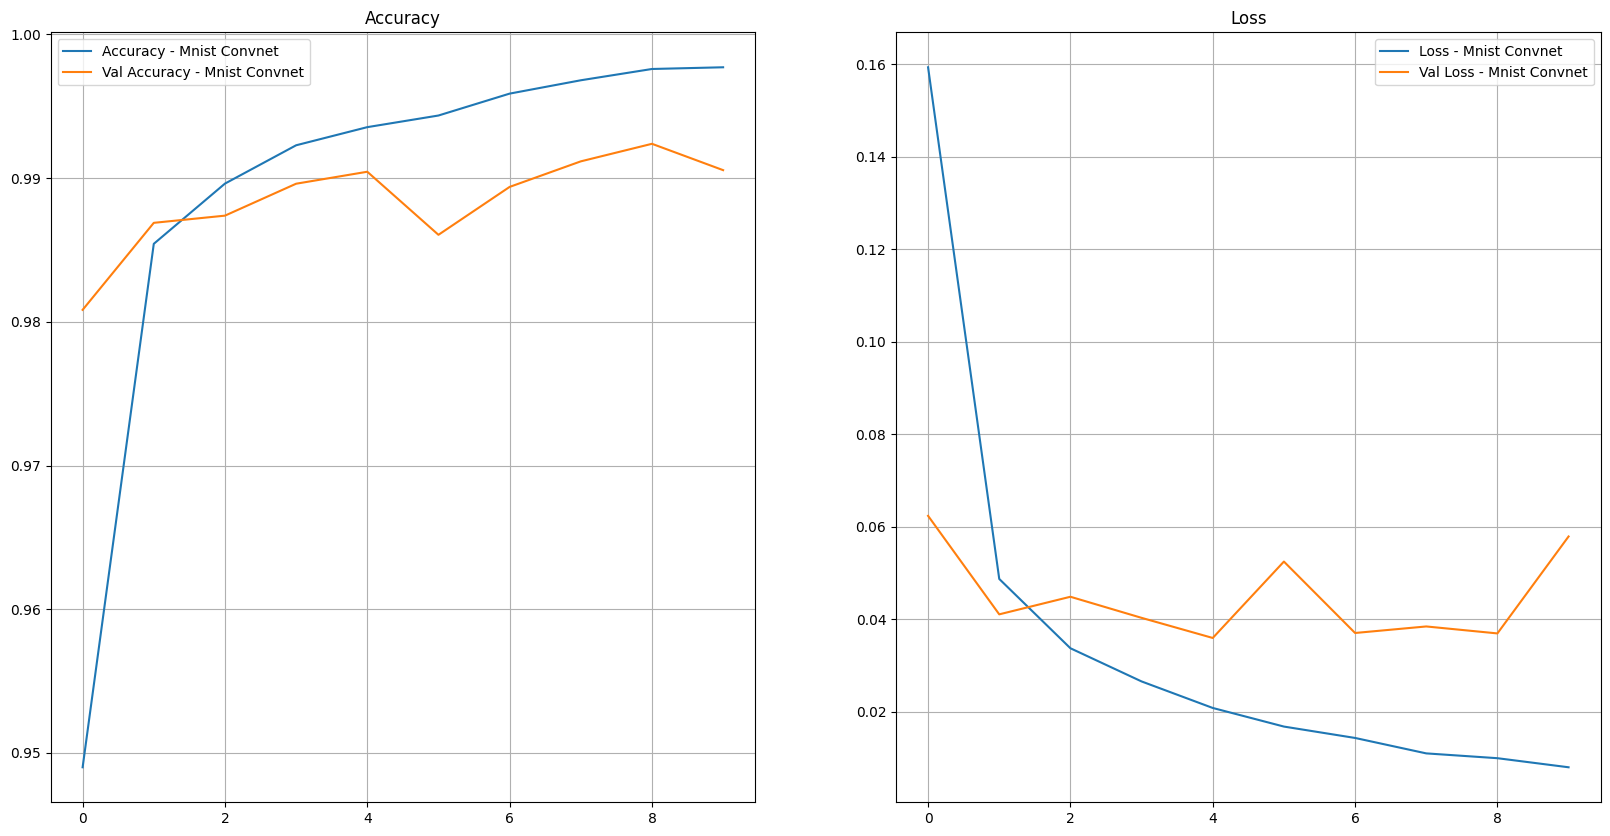

In [9]:
Common.plot(data=[history], labels=["Mnist Convnet"])

---
# **Training from scratch**
---

Notes:
   - image data processing
     - jpeg to rgb float tensors
     - resize 
     - Batches of images
   - tensforflow Datasets API
     - tf.data.Dataset
     - Efficient input pipeline
     - Asynchronous data prefetching (fetch new batch while previous batch is being handled by model)
     - normal vs uniform distributions?


### <ins />**Partitioning**

In [32]:
original_dir = pathlib.Path("../resources/datasets/cats_vs_dogs/")
new_base_dir = pathlib.Path("../resources/datasets/cats_vs_dogs_small")


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)


make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### <ins />**Model**

In [34]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.layers.Rescaling(1.0 / 255)(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu)(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation=tf.nn.relu)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 41, 41, 128)       7385

---
# **Training using feature extraction**
---

In [10]:
dataset = [_ for _ in range(0, 20)]
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# Shuffle
dataset = dataset.shuffle(len(dataset))
# Batch
dataset = dataset.batch(5)
for batch in dataset:
    print("Original: ", batch)
# Reduce
reduced = dataset.reduce(initial_state=0, reduce_func=lambda x, y: x + y)
print("Reduced: ", reduced)
# Map
dataset = dataset.map(lambda x: x * 0)
for batch in dataset:
    print("Mapped: ", batch)

Original:  tf.Tensor([10 14  2  6  8], shape=(5,), dtype=int32)
Original:  tf.Tensor([15 11 19 17  4], shape=(5,), dtype=int32)
Original:  tf.Tensor([13  1 12  7  9], shape=(5,), dtype=int32)
Original:  tf.Tensor([16  0  5 18  3], shape=(5,), dtype=int32)
Reduced:  tf.Tensor([22 45 41 44 38], shape=(5,), dtype=int32)
Mapped:  tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int32)
Mapped:  tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int32)
Mapped:  tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int32)
Mapped:  tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int32)


---
# **Training using fine tuning**
---

---
# **Bottle Detection** 
---

- Design from scratch using Convnet
- Feature extraction using MobileNet with custom logit layer
- Feature extraction using another model with custom logit layer

